<a href="https://colab.research.google.com/github/artyom-zolotarevskiy/gnn-rec-sys/blob/main/%D0%9C%D0%9E%D0%B2%D0%A1%D0%B8%D0%A1%D0%90_%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%97%D0%BE%D0%BB%D0%BE%D1%82%D0%B0%D1%80%D0%B5%D0%B2%D1%81%D0%BA%D0%B8%D0%B8%CC%86_%D0%90_%D0%AE_%D0%9F%D0%9C21_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Построение рекомендательной системы с помощью графовых нейронных сетей использующих атрибуты товаров и пользователей

Золотаревский А. Ю.

**Тип системы**: рекомендательная сеансовая система на основе графовой нейронной сети\
**Реализованная модель**: SR-GNN\
**Датасет**: Retail Rocket Dataset\
**Фреймворк**: Pytorch Geometric

Этапы работы:
  
1. Предобработка данных

2. Построение графов пользовательских сессий

3. Получение эмбеддингов товаров на основе графов сессий

4. Генерация эмбеддингов сессий

5. Обучение модели и совершение рекомендаций

6. Оценка качества полученных результатов

## Установка зависимоcтей и подготовка окружения

**Установка Pytorch Gemoetric**\
Фрейворк PyG - наиболее популярный фреймворк глубокого обучения на графах, построенный поверх PyTorch, который предлагает удобные элементы для использования графовых данных и разработки графовых моделей машинного обучения.


In [1]:
# устанавливаем зависимости
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00


In [2]:
import os
import copy
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import torch_geometric as pyg
import torch_geometric.data as pyg_data

## Предобработка данных

## Сведения о датасете

- Используется открытый датасет **Retail Rocket**, который собран на данных реальных платформ электронной торговли.
- Поведенческие данные, т.е. события взаимодействий, такие как клики, добавление в корзину, покупка, были собраны за период в 4.5 месяца. Они находятся в файле "events.csv".
- Пользователь может совершать 3 типа событий: "view", "addtocart" или "transaction".
-  В общей сумме имеется **2 756 101** событий, включая 2 664 312 "view", 69 332 "addtocart" и 22 457 "transaction", совершенные **1 407 580** уникальных пользователей.
- Файл с характеристиками товаров содержит 20 275 902 строк, т.е. различных характеристик, описывающих 417 053 уникальных товаров.
- В данной работе используется только файл "events.csv".
- Также имеется файл "category_tree.csv", описывающий дерево категорий товаров.

In [3]:
# скачиваем датасет
!wget --user artyom --password zolotarevskiy https://zltrvsk.ru/upload/RetailRocketDataset.zip

--2024-05-12 17:25:49--  https://zltrvsk.ru/upload/RetailRocketDataset.zip
Resolving zltrvsk.ru (zltrvsk.ru)... 95.214.63.131
Connecting to zltrvsk.ru (zltrvsk.ru)|95.214.63.131|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Authorization"
Reusing existing connection to zltrvsk.ru:443.
HTTP request sent, awaiting response... 200 OK
Length: 304719974 (291M) [application/zip]
Saving to: ‘RetailRocketDataset.zip’

RetailRocketDataset 100%[===================>] 290.60M  19.8MB/s    in 16s     

2024-05-12 17:26:06 (18.2 MB/s) - ‘RetailRocketDataset.zip’ saved [304719974/304719974]



In [4]:
# распаковываем датасет
!unzip /content/RetailRocketDataset.zip

Archive:  /content/RetailRocketDataset.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


In [5]:
# смотрим на данные
events_df = pd.read_csv('events.csv')
print(events_df.head())
print(f'Кол-во строк: {len(events_df)}.')

       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN
Кол-во строк: 2756101.


In [6]:
# описательная статистика датасета
events_df.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [7]:
# максимальный уникальный идентификатор товара
max(events_df['itemid'])

466867

## Генерация пользовательских сессий
**Разделений файла с логами на отдельные сеансы**

Данные в исходной форме представлены в формате лога, который необходимо разбить на сессии для всех пользователей.

Применяется стратегия динамической длины сессии, при которой сессия считается завершенной после определенного времени отсутствия активности от пользователя. В данном случае максимальное время простоя установлено в 1 час.


Вот что происходит в ячейках ниже:

1. Отфильтровываются только события просмотра товаров. Ставится задача предсказать товар, который будет просмотрен следующим.
2. Отбрасываются те пользователи, которые имеют всего лишь 1 страницу в истории просмотра.
3. События группируются по идентификатору пользователя visitorid.
4. Полученные группы событий разбиваются на сессии.

In [8]:
# Получаем только события просмотра товаров
events_df_filtered = events_df[events_df['event'] == 'view']
print(f'Кол-во событий просмотра: {len(events_df_filtered)}.')

Кол-во событий просмотра: 2664312.


In [9]:
# Отбрасываем пользователей, которые имеют всего лишь 1 страницу в истории просмотров.
visit_counts_per_visitor = events_df_filtered['visitorid'].value_counts(dropna=False)
visit_counts_per_visitor.head()

visitors_with_significant_visits = visit_counts_per_visitor[
    visit_counts_per_visitor > 1
].index
events_df_filtered = events_df_filtered[
    events_df_filtered['visitorid'].isin(visitors_with_significant_visits)]

In [10]:
# Группируем события по идентификатору пользователя
visits_by_visitors = {}
for _, row in enumerate(tqdm(events_df_filtered.iterrows())):
    timestamp, visitorid, event, itemid, transactionid = row[1].values

    if visitorid not in visits_by_visitors:
        visits_by_visitors[visitorid] = {'itemids': [], 'timestamps': []}
    visits_by_visitors[visitorid]['itemids'].append(itemid)
    visits_by_visitors[visitorid]['timestamps'].append(timestamp)

print()
print(f'Кол-во оставшихся пользователей: {len(visits_by_visitors)}.')

1656582it [01:42, 16105.47it/s]


Кол-во оставшихся пользователей: 396449.


In [11]:
# Максимальное времся простой пользователя 1 час для генерации сессий
delay = 1 * 3600 * 1000

# Разбиение истории посещений каждого пользователя на сессии
sessions_by_visitors = {}
for visitorid, visitor_dict in visits_by_visitors.items():
    sessions = [[]]
    events_sorted = sorted(zip(visitor_dict['timestamps'],
                               visitor_dict['itemids']))
    for i in range(len(events_sorted) - 1):
        sessions[-1].append(events_sorted[i][1])
        if (events_sorted[i+1][0] - events_sorted[i][0]) > delay:
            sessions.append([])
    sessions[-1].append(events_sorted[len(events_sorted) - 1][1])
    sessions_by_visitors[visitorid] = sessions

print()
print(f'Кол-во сессий: {len(sessions_by_visitors)}.')


Кол-во сессий: 396449.


## Разбиение датасета на обучающий и тестовый наборы

- Разбиение происходит по идентификаторам пользователей.
- Каждый пользователь будет присутствовать только в 1 из 3 наборов.
- Берется часть исходного датасета для уменьшения требуемых вычислительных мощностей. Для этого вводится параметр `sampling_rate`, принимающий значения от 0 до 1. Установка 1 приведет к тому, что будет использованы все исходные данные.
- Разбиение на обучающий, валидационный и тестовый наборы идет в процентном соотношении соответственно 80 %, 10% и 10 %.

In [12]:
# Используем половину от исходных данных
sampling_rate = 0.5

seed = 42
all_visitors = list(sessions_by_visitors.keys())
random.Random(seed).shuffle(all_visitors)

num_train = int(len(all_visitors) * 0.8 * sampling_rate)
num_val = int(len(all_visitors) * 0.1 * sampling_rate)
num_test = int(len(all_visitors) * 0.1 * sampling_rate)

train_visitors = all_visitors[:num_train]
val_visitors = all_visitors[num_train : num_train+num_val]
test_visitors = all_visitors[num_train+num_val:num_train+num_val+num_test]

### Аугментация данных

Для увеличения кол-ва обучающих примеров из каждой сессии получаем все подпоследовательности.\
Так сессия (1, 2, 3) даст две отдельных сессии (1, 2) и (1, 2, 3).\
Данный подход соответствует оригинальной статье SR-GNN

In [13]:
def extract_subsessions(sessions):
    all_sessions = []
    for session in sessions:
        for i in range(1, len(session)):
            all_sessions.append(session[:i+1])
    return all_sessions

In [14]:
# Проверим количество пользователей в каждой наборе данных
print(f'Пользователей в train, validation и test: {len(train_visitors), len(val_visitors), len(test_visitors)}')

# Получаем сессии для каждого пользователя
# Генерируем подсессии для каждой сессии
train_sessions, val_sessions, test_sessions = [], [], []
for visitor in train_visitors:
    train_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in val_visitors:
    val_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in test_visitors:
    test_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))

Пользователей в train, validation и test: (158579, 19822, 19822)


Проверим размеры каждой выборки и сохраним предобработанные данные.

In [15]:
print(f'Сессий в train, val и test: {len(train_sessions), len(val_sessions), len(test_sessions)}')

os.makedirs('raw', exist_ok=True)

with open('raw/train.txt', 'wb') as f:
    pickle.dump(train_sessions, f)
with open('raw/val.txt', 'wb') as f:
    pickle.dump(val_sessions, f)
with open('raw/test.txt', 'wb') as f:
    pickle.dump(test_sessions, f)

Сессий в train, val и test: (373755, 49563, 52584)


## Конвеер данных

- Для приема данных используется классы `dataloader` из PyTorch и `Data` из PyG.
- Объект `data` описывает гомогенный граф и может содержать атрибуты узлов, связей и самого графа. Интерфейс этой структуры данных очень похож на обычные словари Python, предоставляя при этом полезную функциональность для анализа графовых струкутур, а также базовые возможноcти оперирования над тензорами от PyTorch.

- Параметры класса **Data** Pytorch Geometric

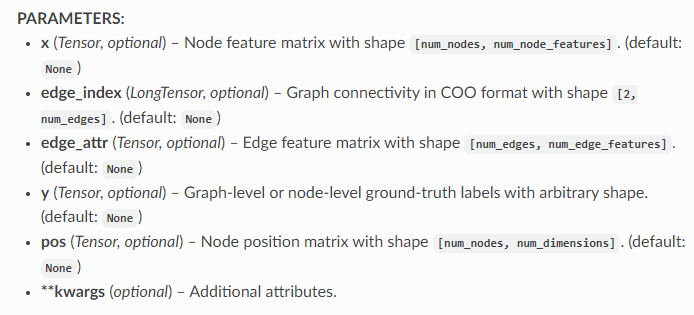

In [16]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.raw_file_names[0]}'
        with open(raw_data_file, 'rb') as f:
            sessions = pickle.load(f)
        data_list = []

        for session in sessions:
            session, y = session[:-1], session[-1]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            # Создаем экземпляр класса Data
            edge_index = torch.tensor(np.array([senders, receivers]))
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1)
            y = torch.tensor([y], dtype=torch.long)
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

## Построение Модели

Модель SR-GNN имеет 3 различных варианта реализации в соответствии с оригинальной статьей. Опишем структуру модели, применнную в данном ноутбуке.


**Модель представляет собой конвеер из 5 модулей:**
1. Использование GGNN (Gated Graph Neural Network) для получения эмбеддингов товаров
2. Применение GRU (Gated Recurrent Unit), который принимает на вход последовательность операций, представляющих собой сессию, а на выходе выдает эмбеддинги этих операций.
3. Затем происходи конкатенация эмбеддингов товаров и операций для формирования, так называемого микро-поведенческого эмбеддинга.
4. Финальное представление сесси вычисляется посредством применения мягкого механизма внимания (soft attention mechanism) к объединенным эмбеддингам
5. В конце модель обучается и оценивается

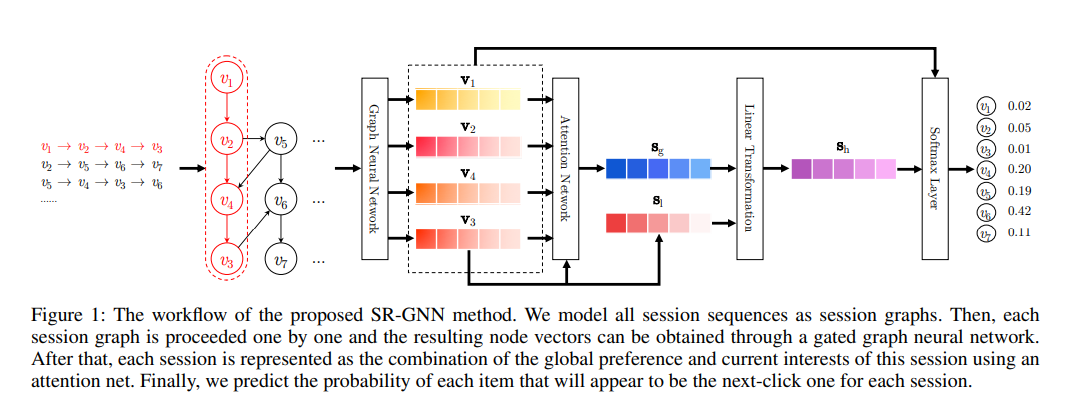

### Получение эмбеддингов товаров

Для начала созданим начальные эмбединги для наших узлов. Для этого мы просто закодируем уникальные идентификаторы товаров в векторную форму эмбеддинга, используя слой `torch.nn.Embedding`

### Слой GG-NN (Gated Graph Neural Network)

Нам требуется улучшить инициированные эмбеддинги. Для этого мы применяем слой Gated Graph Neural Network.

Этот слой состоит из 2-х главных частей:

1. Распространение сообщения для создания матрицы смежности (`self.propagate`).
2. Блок GRU (`self.gru`). Размещен в функции `forward()`.

Мы используем только один слой `GatedSessionGraphConv`, поскольку средняя длина сессий в нашем датасете меньше 5, так что у нас нет потребности в большем количестве.

#### Передача сообщений в PyGeometric
Обобщении оператора свертки для нерегулярных структур данных обычно выражается по схеме передачи сообщений.

PyG предоставляет базовый класс MessagePassing, который помогает в создании такого рода графовых нейронных сетей, автоматически реализуя распространение сообщений. От пользователя требуется только определить функции phi, т.е. message(), gamma, т.е. update(), а также используемую схему агрегации (add, mean или max).

В данном случае используется простая функция передачи сообщений, основная на стратегии агрегации, т.е. путем простого перемножения матрицы смежности и эмбеддинга узла.

Более продвинутые подходы к агрегации могут быть определены в дальнейшем для улучшения производительности, но в нашем случае нет такого разнообразия типов связей в данных, так что можно положиться на простой подход.

In [17]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, aggr: str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        self.out_channels = out_channels
        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m, x)
        return x

    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

In [18]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items

        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        # используем класс message-passing
        self.gated = GatedSessionGraphConv(self.hidden_size)

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # инициализируем эмбеддинги
        embedding = self.embedding(x).squeeze()

        # применяем свертку
        v_i = self.gated(embedding, edge_index)

        # разделяем узлы по сессиям
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        # создаем глобальный эмбеддинг - взвешенное среднее от эмбеддингов товаров в сессии
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        # финальный гибридный эмбеддинг сессии создается путем конкатенации локального и глобального эмбеддингов
        s_l = v_n # локальный эмбеддинг
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        # итогая оценка каждого товара определяется путем вычисления косинусной близости между эмбеддингом сессии (1 x d)
        # и эмбеддингами всех 466867 уникальных товаров (466867 x d)
        z = torch.mm(self.embedding.weight, s_h.T).T
        return z

## Обучение модели

In [19]:
# Определяем гиперпараметры
args = {
    'batch_size': 128,
    'hidden_dim': 64,
    'epochs': 20,
    'l2_penalty': 0.0001,
    'weight_decay': 0.1,
    'step': 5,
    'lr': 0.001,
    'num_items': 466868}

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

In [20]:
def train(args):
    # Подготавливаем конвеер данных
    train_dataset = GraphDataset('./', 'train')
    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       drop_last=True)
    val_dataset = GraphDataset('./', 'val')
    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=args.batch_size,
                                     shuffle=False,
                                     drop_last=True)

    # Строим модель
    model = SRGNN(args.hidden_dim, args.num_items).to('cuda')

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2_penalty)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step, gamma=args.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Обучаем
    losses = []
    test_accs = []
    top_k_accs = []

    best_acc = 0
    best_model = None

    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to('cuda')
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
            test_acc, top_k_acc = test(val_loader, model, is_validation=True)
            print(test_acc)
            test_accs.append(test_acc)
            top_k_accs.append(top_k_acc)
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = copy.deepcopy(model)
            else:
                test_accs.append(test_accs[-1])

    return test_accs, top_k_accs, losses, best_model, best_acc, val_loader

In [21]:
def test(loader, test_model, is_validation=False, save_model_preds=False):
    test_model.eval()

    # Определяем K для метрики Hit@K
    k = 10
    correct = 0
    top_k_correct = 0

    for _, data in enumerate(tqdm(loader)):
        data.to('cuda')
        with torch.no_grad():
            score = test_model(data)
            # max(dim=1) возвращает значения и кортеж индексов, нужны только индексы
            pred = score.max(dim=1)[1]
            label = data.y

        if save_model_preds:
            data = {}
            data['pred'] = pred.view(-1).cpu().detach().numpy()
            data['label'] = label.view(-1).cpu().detach().numpy()

            df = pd.DataFrame(data=data)
            # Save locally as csv
            df.to_csv('pred.csv', sep=',', index=False)

        correct += pred.eq(label).sum().item()

        # Рассчитываем метрику Hit@K только на тестовой выборке
        if not is_validation:
            score = score.cpu().detach().numpy()
            for row in range(pred.size(0)):
                top_k_pred = np.argpartition(score[row], -k)[-k:]
                if label[row].item() in top_k_pred:
                    top_k_correct += 1

    if not is_validation:
        return correct / len(loader), top_k_correct / len(loader)
    else:
        return correct / len(loader), 0

In [22]:
plt.rcParams["figure.figsize"] = (12, 8)

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Processing...
Done!
100%|██████████| 387/387 [00:17<00:00, 21.69it/s]


13.87080103359173


100%|██████████| 387/387 [00:10<00:00, 35.22it/s]


13.330749354005167


100%|██████████| 387/387 [00:10<00:00, 36.77it/s]


15.025839793281653


100%|██████████| 387/387 [00:09<00:00, 39.24it/s]


15.772609819121447


100%|██████████| 387/387 [00:09<00:00, 39.34it/s]


16.56847545219638


100%|██████████| 387/387 [00:07<00:00, 50.93it/s]


18.956072351421188


100%|██████████| 387/387 [00:08<00:00, 47.87it/s]


19.43152454780362


100%|██████████| 387/387 [00:07<00:00, 53.31it/s]


19.54780361757106


100%|██████████| 387/387 [00:07<00:00, 55.08it/s]


19.733850129198967


100%|██████████| 387/387 [00:07<00:00, 53.60it/s]


19.97157622739018


100%|██████████| 387/387 [00:08<00:00, 43.48it/s]


20.00516795865633


100%|██████████| 387/387 [00:09<00:00, 40.26it/s]


20.020671834625322


100%|██████████| 387/387 [00:08<00:00, 46.18it/s]


20.041343669250647


100%|██████████| 387/387 [00:08<00:00, 44.09it/s]


20.0671834625323


100%|██████████| 387/387 [00:09<00:00, 39.64it/s]


20.10594315245478


100%|██████████| 387/387 [00:09<00:00, 39.98it/s]


20.11627906976744


100%|██████████| 387/387 [00:08<00:00, 43.64it/s]


20.11111111111111


100%|██████████| 387/387 [00:08<00:00, 43.20it/s]


20.124031007751938


100%|██████████| 387/387 [00:09<00:00, 42.38it/s]


20.126614987080103


100%|██████████| 387/387 [00:08<00:00, 46.47it/s]


20.152454780361758
[13.87080103359173, 13.330749354005167, 13.330749354005167, 15.025839793281653, 15.772609819121447, 16.56847545219638, 18.956072351421188, 19.43152454780362, 19.54780361757106, 19.733850129198967, 19.97157622739018, 20.00516795865633, 20.020671834625322, 20.041343669250647, 20.0671834625323, 20.10594315245478, 20.11627906976744, 20.11111111111111, 20.11111111111111, 20.124031007751938, 20.126614987080103, 20.152454780361758] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Максимальная точность на тестовом наборе: 20.152454780361758
Минимальная ощибка: 5.503988028095073


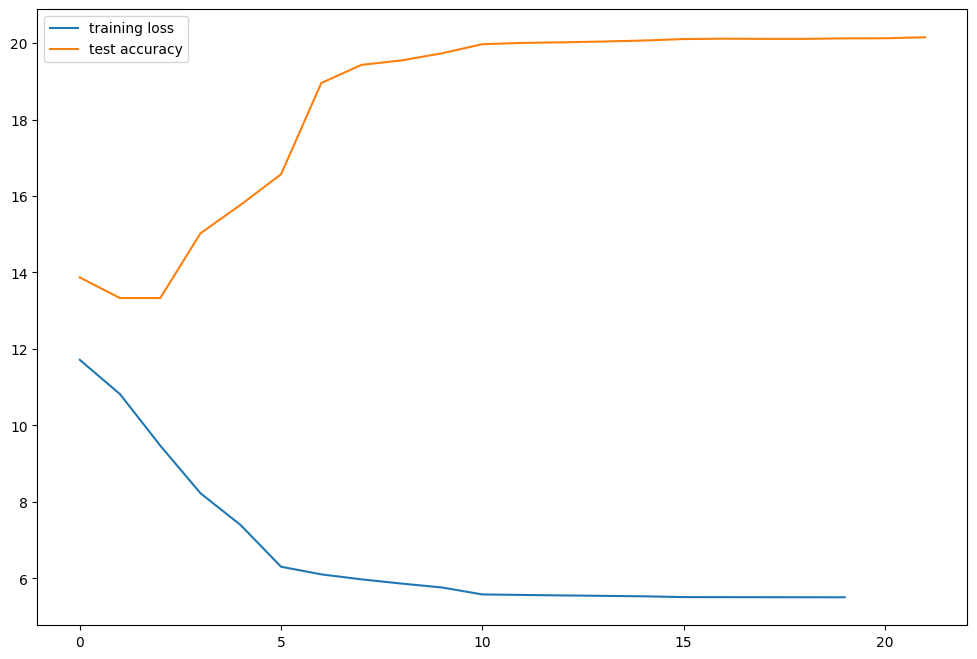

In [23]:
test_accs, top_k_accs, losses, best_model, best_acc, test_loader = train(args)

print(test_accs, top_k_accs)
print("Максимальная точность на тестовом наборе: {0}".format(max(test_accs)))
print("Минимальная ошибка: {0}".format(min(losses)))

plt.plot(losses, label="training loss")
plt.plot(test_accs, label="test accuracy")
plt.legend()
plt.show()

Точность на валидационных данных составила: 20.15 %

## Оценка модели

In [24]:
# Сохраним нашу лучшую модель
torch.save(best_model.state_dict(), 'model')

In [25]:
# Запустим тесты для нашей лучшей модели и сохраним предсказания
test_dataset = GraphDataset('./', 'test')
test_loader = pyg_data.DataLoader(test_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  drop_last=True)

test(test_loader, best_model, is_validation=False, save_model_preds=True)

Processing...
Done!
100%|██████████| 410/410 [10:25<00:00,  1.53s/it]


(19.724390243902437, 43.19268292682927)

### Результаты оценки:

- Модель может предсказать какой следующий товар заинтересует пользователя вероятностью 20 %
- Мы получили Hit@10 = 43.2 %, а это значит, что если наша модель рекомендует 10 товаров, то 4 из них будут соответствовать интересам пользователя. Это весьма хороший показатель качества нашей модели.

## Ссылки:


- https://arxiv.org/pdf/1811.00855.pdf
- https://github.com/CRIPAC-DIG/SR-GNN
- https://colab.research.google.com/drive/1X4uOWv_xkefDu_h-pbJg-fEkMfR7NGz9?usp=sharing
- https://github.com/userbehavioranalysis/SR-GNN_PyTorch-Geometric
- https://pytorch-geometric.readthedocs.io/
- Shoujin Wang, Longbing Cao, Yan Wang, Quan Z. Sheng, Mehmet A. Orgun, and Defu Lian. 2021. A Survey on Session-based Recommender Systems. ACM Comput. Surv. 9, 4, Article 39 (May 2021), 39 pages. https: //doi.org/0000001.0000001
- Wenjing Meng, Deqing Yang and Yanghua Xiao. 2020. Incorporating User Micro-behaviors and Item Knowledge into Multi-task Learning for Session-based Recommendation. In Proceedings of the 43rd International ACM.
- Li, Yujia, et al. “Gated graph sequence neural networks.” arXiv preprint arXiv:1511.05493 (2015).
- Wu, Shiwen, et al. “Graph neural networks in recommender systems: a survey.” arXiv preprint arXiv:2011.02260 (2020).